### Install Necessary Packages

In [ ]:
!conda create -n scvi-env
!conda activate scvi-env
!conda install pytorch-cpu torchvision-cpu -c pytorch
!pip install scanpy
!pip install pandas
!pip install seaborn
!pip install -U jax
!pip install scvi-tools -c conda-forge

In [1]:
import torch
import scvi
import scanpy as sc

Global seed set to 0


## scVI Integration
This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). 

The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space.

In [44]:
reference = sc.read_h5ad('reference.h5ad')
query = sc.read_h5ad('query.h5ad')

In [45]:
reference.raw = reference
reference.layers['counts'] = reference.X

query.raw = query
query.layers['counts'] = query.X

In [46]:
sc.pp.highly_variable_genes(reference, n_top_genes=2000, batch_key="project", subset=True,span=0.5,layer = 'counts',flavor = 'seurat_v3')

query = query[:,query.var_names.isin(reference.var_names)]

We train the reference using the standard SCVI workflow

In [47]:
scvi.model.SCVI.setup_anndata(reference, batch_key="project",layer = 'counts')
scvi_ref = scvi.model.SCVI(
    reference,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
scvi_ref.train()

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount(

Epoch 1/81:   0%|          | 0/81 [00:00<?, ?it/s]

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 81/81: 100%|██████████| 81/81 [23:10<00:00, 17.16s/it, loss=834, v_num=1]


In [48]:
SCVI_LATENT_KEY = "X_scVI"

reference.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(reference, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(reference)
sc.tl.umap(reference)

## Update with query
We can load a new model with the query data either using

The saved reference model

The instance of the reference model

In [63]:
#Need to add this layer as prepary_query_anndata looks for ._X instead of .X as it should
query._X = query.X

In [64]:
scvi.model.SCVI.prepare_query_anndata(query, scvi_ref,inplace=True)

INFO     Found 99.75% reference vars in query data.                                                                


/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [65]:
scvi_query = scvi.model.SCVI.load_query_data(
    query,
    scvi_ref,
)

This step can take a large amount of time (~30 min) and setting up to run on GPU is recommended

In [66]:
scvi_query.train(max_epochs=200, plan_kwargs={"weight_decay": 0.0})
query.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 200/200: 100%|██████████| 200/200 [35:59<00:00, 10.80s/it, loss=1.14e+03, v_num=1]


In [67]:
sc.pp.neighbors(query, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(query)
sc.tl.umap(query)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

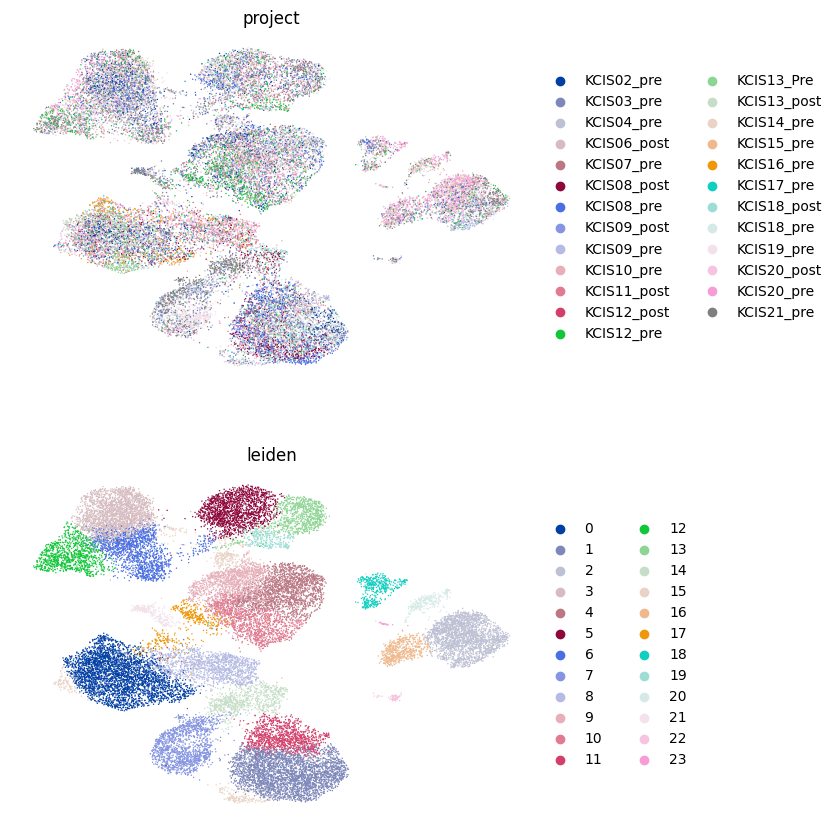

In [71]:
sc.pl.umap(
    query,
    color=["project", "leiden"],
    frameon=False,
    ncols=1,
)

## Predict Cell Type Labels of Query with SCANVI
SCANVI builds off of scVI model and uses a semi-supervised model trained on reference data to then make predictions on query

In [72]:
SCANVI_LABELS_KEY = "labels_scanvi"

reference.obs[SCANVI_LABELS_KEY] = reference.obs["cell_type"].values

In [73]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
scanvi_ref = scvi.model.SCANVI.from_scvi_model(
    scvi_ref,
    unlabeled_category="Unknown",
    labels_key=SCANVI_LABELS_KEY,
)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()


Train reference scANVI model

In [74]:
scanvi_ref.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 20/20: 100%|██████████| 20/20 [12:38<00:00, 37.93s/it, loss=906, v_num=1]


In [75]:
SCANVI_LATENT_KEY = "X_scANVI"

reference.obsm[SCANVI_LATENT_KEY] = scanvi_ref.get_latent_representation()

### Update With Query
Here we apply our trained scANVI model on reference data to our new dataset

In [77]:
#save model (not required)
scanvi_ref_path ="scanvi_ref"
scanvi_ref.save(scanvi_ref_path, overwrite=True)

We need to make sure metadata columns match, so add new labels_scanvi column to query metadata

In [88]:
query.obs['labels_scanvi'] = 'Unknown'

In [90]:
scvi.model.SCANVI.prepare_query_anndata(query,scanvi_ref_path)
scanvi_query = scvi.model.SCANVI.load_query_data(query,scanvi_ref_path)

INFO     File scanvi_ref/model.pt already downloaded                                                               
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File scanvi_ref/model.pt already downloaded                                                               


/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()


train our scANVI model

In [91]:
scanvi_query.train(
    max_epochs=100,
    plan_kwargs={"weight_decay": 0.0},
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100/100: 100%|██████████| 100/100 [09:00<00:00,  5.41s/it, loss=1.17e+03, v_num=1]


Add SCANVI latent representation and Predict Cell Types for Cells

In [93]:
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

query.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
query.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

Plot Predictions

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

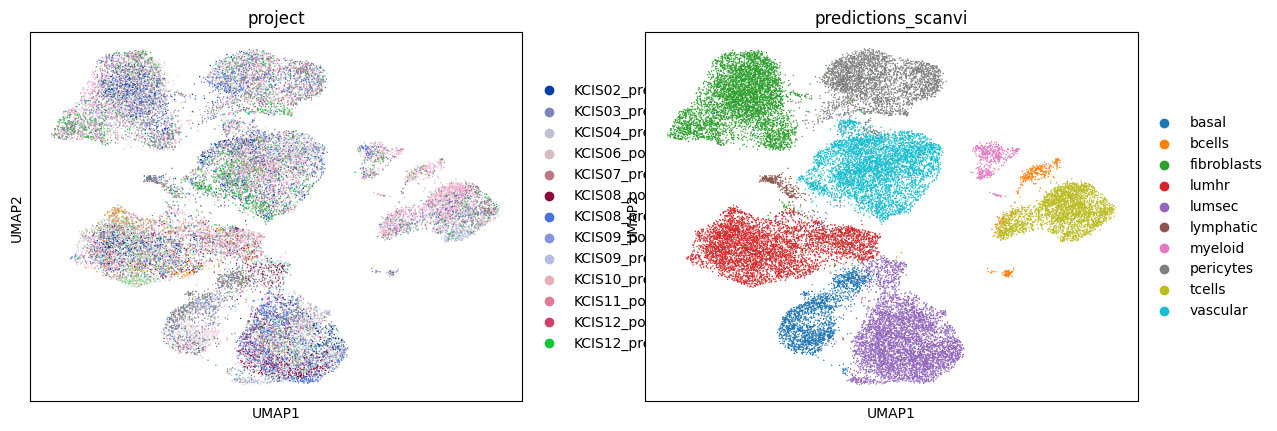

In [97]:
sc.pl.umap(query,color = ['project','predictions_scanvi'])